# **Esempio 5. Unsupervised learning applicato alla geometrica molecolare**

In questo esempio si proverà a fornire in input a un algoritmo *k-means clustering* un dataset costituito da descrittori geometrici di piccole molecole organiche. Tali descrittori saranno correlati alla distribuzione dei nuclei lungo le tre direzioni dello spazio. Cercando 3 cluster, una correlazione che potrebbe emergere riguardo l'etensione spaziale delle molecole. Sarà l'algoritmo in grado di imparare a separare le molecole in lineari, planari e tridimensionali?

Eseguire la seguenta cella se è necessario installare le librerie.

In [1]:
%%capture
!pip install rdkit
!pip install git+https://github.com/mordred-descriptor/mordred
!pip install py3Dmol

La cella che segue carica librerie e moduli che saranno necessari.

In [2]:
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

import py3Dmol

import mordred
from mordred import Calculator

## **Dataset**
Il dataset è costituito da piccole molecole organiche.

In [3]:
url='https://drive.google.com/file/d/14G1-NOgbXLaIFZUPARSfpEP3DimuHAE2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_table(url, encoding='windows-1252', delimiter=';')

display(data)

SMILES Dimensioni
0                          F         1D
1                         Cl         1D
2                         Br         1D
3                          I         1D
4                         FF         1D
5                       ClCl         1D
6                       BrBr         1D
7                         II         1D
8                    C(=O)=O         1D
9                      S=C=S         1D
10                     [OH-]         1D
11                     [SH-]         1D
12                       C#N         1D
13                       C#C         1D
14                 [C-]#[O+]         1D
15                     [N]=O         1D
16                N#[N+][O-]         1D
17                  N(=O)[O]         2D
18                         O         2D
19                  c1ccccc1         2D
20  [O-][N+](=O)[N+]([O-])=O         2D
21                    C=CC=C         2D
22                c1cc[nH]c1         2D
23                   F/C=C/F         2D
24                 Cl/C=C\Br         2D
25                 ClC(=O)Cl         2D
26                     ClC=C         2D
27                         S         2D
28                     BrC=O         2D
29                     O=S=O         2D
30                    c1ccc1         2D
31                       C=O         2D
32                 ClC(=O)Cl         2D
33                       C=C         2D
34                    O=C=NC         3D
35                 O=S(Cl)Cl         3D
36                  C(=O)OCC         3D
37                  C1COCCO1         3D
38               OS(O)(=O)=O         3D
39                     CCC=C         3D
40                     [NH3]         3D
41                  C1CCCCC1         3D
42                     C1CC1         3D
43                     C=C=C         3D
44                         C         3D
45                   ClC(Cl)         3D
46                        CO         3D
47                        CC         3D
48                       CCC         3D
49                  CC(Br)CO         3D
50               CC(C(=O)O)N         3D

Interpreta la stringa SMILES e rappresenta le molecole.

In [4]:
smiles_str = data.SMILES.astype(str).to_list()
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_str]

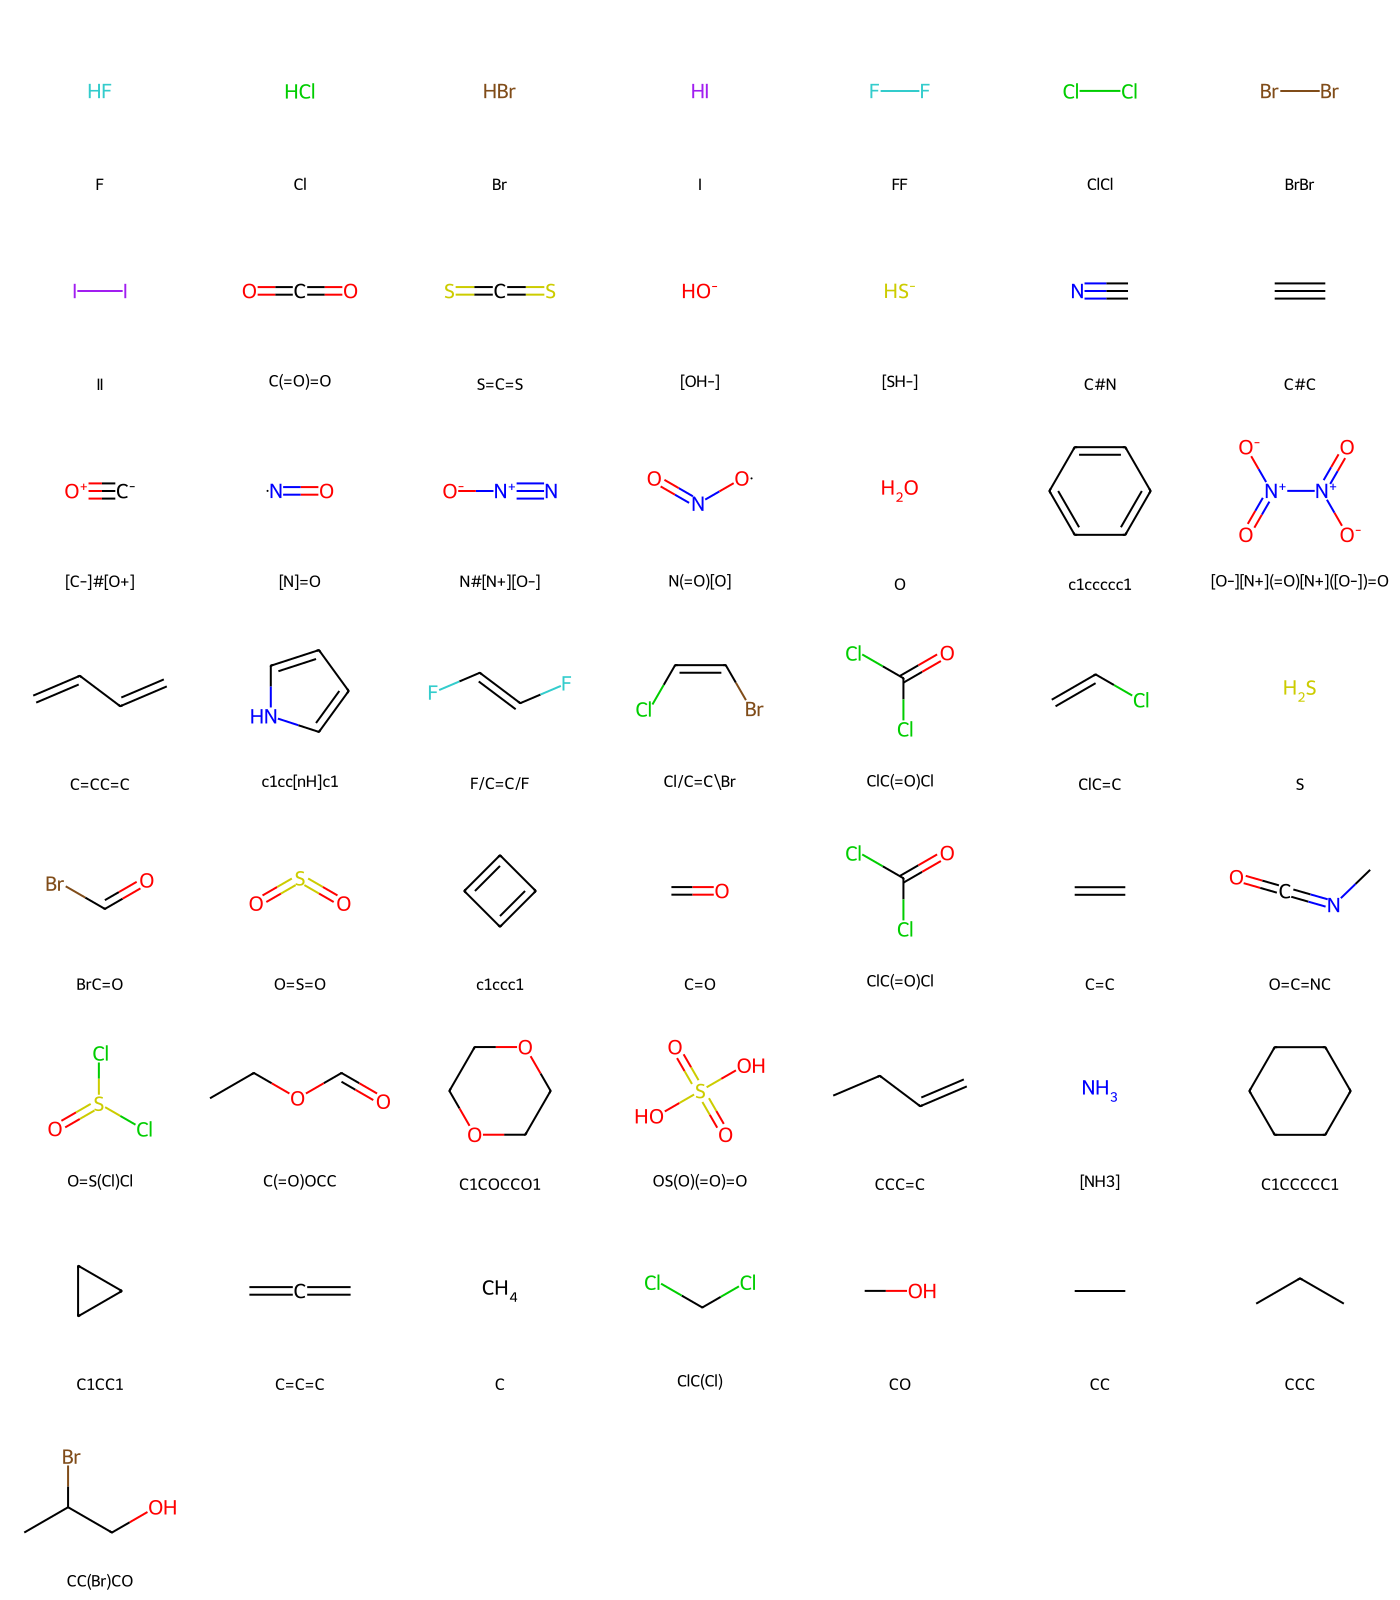

In [6]:
Draw.MolsToGridImage(mols, molsPerRow=7,subImgSize=(200,200), legends=[str(x) for x in data['SMILES']])

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Funzione che rappresenta la molecola
def viewmol(Specie):
  i = data.loc[(data == Specie).any(axis=1)].index[0]

  # Aggiunge gli atomi di H
  m = Chem.AddHs(mols[i])

  # Crea le coordinate Cartesiane
  AllChem.Compute2DCoords(m)
  AllChem.EmbedMolecule(m)

  # Esegue una semplice ottimizzazione di geometria
  AllChem.MMFFOptimizeMolecule(m, maxIters=1000, mmffVariant='MMFF94s')

  # Output della geometria
  print(Chem.MolToMolBlock(m))

  # Rappresentazione 3D
  mblock = Chem.MolToMolBlock(m)
  view = py3Dmol.view(width=600, height=600)
  view.addModel(mblock, 'mol')
  view.setStyle('stick')
  view.zoomTo()
  view.show()

# Dropdown menù per la scelta della specie
interact(viewmol, Specie = data['SMILES']);

interactive(children=(Dropdown(description='Specie', options=('F', 'Cl', 'Br', 'I', 'FF', 'ClCl', 'BrBr', 'II'…

La cella che segue trasla le molecole nel loro centro di massa e le orienta secondo le direzioni principali di inerzia. Infine, calcola la massima distanza tra gli atomi lungo le tre coordinate Cartesiane.

In [15]:
delta_xyz = np.zeros([len(mols), 3])
PM = np.zeros(len(mols))

for i in range (0, len(mols)):

  # Aggiunge gli H
  mols[i] = Chem.AddHs(mols[i])

  # Crea le coordinate Cartesiane
  AllChem.Compute2DCoords(mols[i])
  AllChem.EmbedMolecule(mols[i])

  # Esegue una semplice ottimizzazione di geometria
  AllChem.MMFFOptimizeMolecule(mols[i], maxIters=1000, mmffVariant='MMFF94')
  mols[i].GetConformer()

  # Trasla rispetto al centro di massa
  cm = np.zeros(3)
  M = 0.0
  for n, atom in enumerate(mols[i].GetAtoms()):
    positions = mols[i].GetConformer().GetAtomPosition(n)
    cm = cm + atom.GetMass() * np.array(tuple(positions))
    M = M + atom.GetMass()

  cm = cm / M
  PM[i] = M

  # Calcola il tensore di inerzia
  II = np.zeros([3, 3])
  for n, atom in enumerate(mols[i].GetAtoms()):
    mols[i].GetConformer().SetAtomPosition(n, mols[i].GetConformer().GetAtomPosition(n) - cm)
    positions = mols[i].GetConformer().GetAtomPosition(n)
    II[0, 0] = II[0, 0] + atom.GetMass() * (positions.y**2 + positions.z**2)
    II[0, 1] = II[0, 1] - atom.GetMass() * (positions.x * positions.y)
    II[0, 2] = II[0, 2] - atom.GetMass() * (positions.x * positions.z)
    II[1, 1] = II[1, 1] + atom.GetMass() * (positions.x**2 + positions.z**2)
    II[1, 2] = II[1, 2] - atom.GetMass() * (positions.y * positions.z)
    II[2, 2] = II[2, 2] + atom.GetMass() * (positions.x**2 + positions.y**2)

  II[1, 0] = II[0, 1]
  II[2, 0] = II[0, 2]
  II[2, 1] = II[1, 2]

  # Diagonalizza il tensore di inerzia
  Ie, IV = np.linalg.eig(II)

  # Esprime le cordinate nel sistema principale di inerzia
  for n, atom in enumerate(mols[i].GetAtoms()):
    positions = np.array(tuple(mols[i].GetConformer().GetAtomPosition(n)))
    positions = np.matmul(np.transpose(IV), positions)
    mols[i].GetConformer().SetAtomPosition(n, positions)

  # Calcola le distanze max
  dx = 0.0
  dy = 0.0
  dz = 0.0
  for n in range (0, mols[i].GetNumAtoms()):
    positions = np.array(tuple(mols[i].GetConformer().GetAtomPosition(n)))
    for m in range (n+1, mols[i].GetNumAtoms()):
      posM = np.array(tuple(mols[i].GetConformer().GetAtomPosition(m)))
      tmpdx = np.abs(positions[0] - posM[0])
      if (tmpdx > dx):
        dx = tmpdx
      tmpdy = np.abs(positions[1] - posM[1])
      if (tmpdy > dy):
        dy = tmpdy
      tmpdz = np.abs(positions[2] - posM[2])
      if (tmpdz > dz):
        dz = tmpdz

  delta_xyz[i, :] = np.sort([dx, dy, dz])

[15:50:16] UFFTYPER: Unrecognized charge state for atom: 0


Nella cella che segue vengono calcolate altri descrittori molecolari, che si possono usare per notare come cambia la classificazione dispetto ai parametri calcolati nella cella precedente.

In [12]:
# Importa le categorie di descrittori da calcolare
from mordred import MomentOfInertia, AtomCount

# Crea il calcolatore di descrittori
calc = Calculator()

# Aggiunge i descrittori da calcolare
calc.register(MomentOfInertia)               # le 3 compoenenti principali del tensore d'inerzia
calc.register(AtomCount.AtomCount('Atom'))
calc.register(AtomCount.AtomCount('H'))

# Crea il DataFrame con i descrittori
descr = calc.pandas(mols)

descr.insert(0, 'Dimensioni', data['Dimensioni'])
descr.insert(1, 'Dx', delta_xyz[:, 0])
descr.insert(2, 'Dy', delta_xyz[:, 1])
descr.insert(3, 'Dz', delta_xyz[:, 2])

display(descr)

100%|██████████| 51/51 [00:00<00:00, 164.70it/s]


Dimensioni            Dx            Dy         Iz         Iy            Ix  \
0          1D  0.000000e+00  0.000000e+00   0.866527   0.866527  0.000000e+00   
1          1D  0.000000e+00  0.000000e+00   1.765527   1.765527  0.000000e+00   
2          1D  0.000000e+00  0.000000e+00   2.291004   2.291004  0.000000e+00   
3          1D  0.000000e+00  0.000000e+00   2.900866   2.900866  0.000000e+00   
4          1D  0.000000e+00  0.000000e+00   1.095200   1.095200  0.000000e+00   
5          1D  0.000000e+00  0.000000e+00   2.040202   2.040202  0.000000e+00   
6          1D  0.000000e+00  0.000000e+00   2.644999   2.644999  0.000000e+00   
7          1D  0.000000e+00  0.000000e+00   3.537800   3.537800  0.000000e+00   
8          1D  0.000000e+00  1.213936e-07   3.948049   3.948049  1.021405e-14   
9          1D  0.000000e+00  4.081755e-06   6.468089   6.468089  1.264766e-11   
10         1D  0.000000e+00  0.000000e+00   0.849489   0.849489  0.000000e+00   
11         1D  0.000000e+00  0.000000e+00   1.722988   1.722988  0.000000e+00   
12         1D  0.000000e+00  1.494630e-09   3.318928   3.318928  0.000000e+00   
13         1D  4.527782e-08  2.439532e-06   6.271178   6.271178  9.361522e-12   
14         1D  0.000000e+00  0.000000e+00   0.645646   0.645646  0.000000e+00   
15         1D  0.000000e+00  0.000000e+00   1.018245   1.018245  0.000000e+00   
16         1D  0.000000e+00  7.164325e-08   3.181856   3.181856  3.552714e-15   
17         2D  0.000000e+00  8.339417e-01   3.129565   2.664188  4.653774e-01   
18         2D  0.000000e+00  5.967226e-01   1.731910   1.165766  5.661432e-01   
19         2D  1.984976e-05  4.304070e+00  24.310986  24.310959  4.862195e+01   
20         2D  2.335989e-05  2.206746e+00   8.700323  13.570042  4.869719e+00   
21         2D  2.261676e-06  2.989417e+00  30.492531  38.641200  8.148669e+00   
22         2D  6.033146e-06  3.984765e+00  15.999108  16.066573  3.206568e+01   
23         2D  1.885047e-06  2.241630e+00   8.217449  12.158738  3.941289e+00   
24         2D  3.623387e-07  3.675106e+00  23.544027  15.548371  7.995656e+00   
25         2D  2.547394e-08  2.213726e+00   4.160571   3.729102  7.889673e+00   
26         2D  1.418281e-07  2.875464e+00  19.617342  14.909276  4.708066e+00   
27         2D  0.000000e+00  9.198766e-01   3.405239   1.904218  1.501021e+00   
28         2D  3.637454e-07  2.050287e+00   8.966316  11.108051  2.141735e+00   
29         2D  0.000000e+00  9.149878e-01   4.450387   3.822033  6.283535e-01   
30         2D  8.380487e-07  2.899575e+00  10.701680  10.218775  2.092045e+01   
31         2D  2.684029e-08  1.812283e+00   5.370162   3.633346  1.736817e+00   
32         2D  3.680558e-09  2.213726e+00   4.160571   3.729102  7.889673e+00   
33         2D  5.238251e-07  1.859915e+00   6.921933  10.381215  3.459283e+00   
34         3D  1.437149e+00  1.787726e+00  19.894820  19.267540  3.823244e+00   
35         3D  9.089430e-01  2.220333e+00   5.272721   4.110741  8.305896e+00   
36         3D  1.791836e+00  2.160510e+00  43.730678  40.235484  9.801493e+00   
37         3D  1.899375e+00  2.450377e+00  44.281273  34.245287  2.233259e+01   
38         3D  1.930145e+00  2.064930e+00  12.084975  14.365974  8.500376e+00   
39         3D  2.915824e+00  2.976286e+00  40.055299  37.861525  1.359529e+01   
40         3D  3.941300e-01  1.515941e+00   1.644645   1.644652  2.649071e+00   
41         3D  2.638929e+00  4.765020e+00  42.880715  42.880703  6.389378e+01   
42         3D  1.821696e+00  2.372207e+00  12.456105  12.455899  1.495667e+01   
43         3D  1.316895e+00  1.319920e+00  18.790542  18.798516  3.476325e+00   
44         3D  1.609625e+00  1.675486e+00   3.181065   3.181065  3.181067e+00   
45         3D  1.628195e+00  1.787001e+00   5.846466   6.527345  9.180438e+00   
46         3D  1.483815e+00  1.791065e+00   7.907715   7.394177  3.721453e+00   
47         3D  1.810182e+00  2.047339e+00  12.094075  12.094077  6.295671e+00   
48         3D  1.774488e+00  2.142

Addestramento sul 70% dei dati.

Dx            Dy        Dz Dimensioni  Label
40  1.755158e-01  6.750858e-01  0.716557         3D      2
38  4.364993e-01  4.669808e-01  0.769024         3D      1
19  3.021536e-06  6.551667e-01  0.755484         2D      2
24  6.812900e-08  6.910146e-01  0.722841         2D      2
13  1.358915e-08  7.321720e-07  1.000000         1D      0
42  4.688979e-01  6.105977e-01  0.638205         3D      1
17  0.000000e+00  3.397811e-01  0.940505         2D      2
46  4.325817e-01  5.221552e-01  0.735001         3D      1
36  3.098761e-01  3.736338e-01  0.874285         3D      1
23  4.869261e-07  5.790349e-01  0.815303         2D      2
4   0.000000e+00  0.000000e+00  1.000000         1D      0
34  3.087176e-01  3.840259e-01  0.870182         3D      1
14  0.000000e+00  0.000000e+00  1.000000         1D      0
31  1.032471e-08  6.971348e-01  0.716940         2D      2
10  0.000000e+00  0.000000e+00  1.000000         1D      0
28  1.130728e-07  6.373462e-01  0.770578         2D      2
45  4.299045e-01  4.718353e-01  0.769775         3D      1
35  2.329556e-01  5.690556e-01  0.788611         3D      1
18  0.000000e+00  3.639899e-01  0.931403         2D      2
20  6.656553e-06  6.288267e-01  0.777545         2D      2
25  7.005708e-09  6.088072e-01  0.793318         2D      2
6   0.000000e+00  0.000000e+00  1.000000         1D      0
7   0.000000e+00  0.000000e+00  1.000000         1D      0
48  3.467588e-01  4.187317e-01  0.839299         3D      1
1   0.000000e+00  0.000000e+00  1.000000         1D      0
16  0.000000e+00  2.853265e-08  1.000000         1D      0
0   0.000000e+00  0.000000e+00  1.000000         1D      0
15  0.000000e+00  0.000000e+00  1.000000         1D      0
5   0.000000e+00  0.000000e+00  1.000000         1D      0
11  0.000000e+00  0.000000e+00  1.000000         1D      0
9   0.000000e+00  1.134864e-06  1.000000         1D      0
8   0.000000e+00  4.320057e-08  1.000000         1D      0
12  0.000000e+00  6.717437e-10  1.000000         1D      0
43  3.178331e-01  3.185629e-01  0.893028         3D      1
37  3.695463e-01  4.767504e-01  0.797587         3D      1

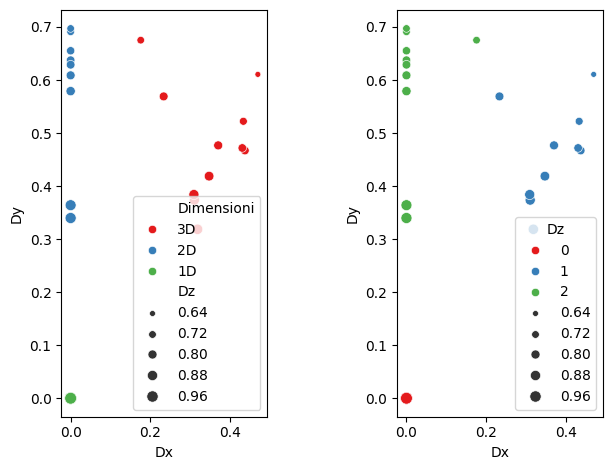

In [18]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

features = ['Dx', 'Dy', 'Dz']
X = descr[features]
y = descr['Dimensioni']

# Normalizazzione dei dati
from sklearn import preprocessing
X_norm = preprocessing.normalize(X)
Xndf = pd.DataFrame({features[0]:X_norm[:,0],features[1]:X_norm[:,1],features[2]:X_norm[:,2]})

# Suddivide il dataset in training and testing
X_train, X_test, y_train, y_test = train_test_split(Xndf, y, test_size=0.3, random_state=1) # 70% training and 30% test


fig, axs = plt.subplots(ncols=2)
sns.scatterplot(data = X_train, x = features[0], y = features[1], hue = y_train, size = features[2], palette="Set1", ax=axs[0]);

# Clustering
knn = KMeans(n_clusters=3, random_state=1, n_init='auto')
knn.fit(X_train)
labels = knn.labels_
sns.scatterplot(data = X_train, x = features[0], y = features[1], size = features[2], hue = labels, palette="Set1", ax=axs[1]);

# Tabella di output
out = X_train.copy(deep=True)
out.insert(3,'Dimensioni', y_train)
out.insert(4,'Label', labels)
display(out)

plt.subplots_adjust(wspace=5.0)
plt.tight_layout()
plt.show()

In [19]:
# Testing
y_pred = knn.predict(X_test)
testdb = pd.DataFrame({'Dimensioni':y_test,'Label':y_pred})
display(testdb)

Dimensioni  Label
22         2D      2
2          1D      0
49         3D      1
26         2D      2
33         2D      2
44         3D      1
30         2D      2
50         3D      1
32         2D      2
27         2D      2
3          1D      0
29         2D      2
47         3D      1
41         3D      1
39         3D      1
21         2D      2